In [1]:
import json
import codecs
from datetime import datetime
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve

import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydot

from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV


/Users/ssvalipour/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ssvalipour/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
path= "/Users/ssvalipour/Downloads/tweet/english10k_tweets.json"

tweets = []
with open(path) as f:
    for line in f:
        tweets.append(json.loads(line))

In [3]:
len(tweets)

10000

In [4]:
# Define on dictionary as key for deviceType and value as our classification
device_type= {'Twitter for Iphone':'mobile', 'Twitter for Android':'mobile',
    'Twitter Web Client':'web', "Tweetbot for Mac":'web',
    'Instagram':'app', 'Tumblr':'app', 'Foursquared':'app',
    'Falcon Social Media Management':'smm', 'TweetDeck':'smm', 'dlvr.it':'smm',
    'Trendsmap Alerting':'bot', 'SpotifyNowPlaying':'bot'}

In [5]:
target_name=list(device_type.values())
target_name.append('other')
target_name=list(set(target_name))
device_type2ID=dict(zip(target_name,range(len(target_name))))
ID2device_type=dict(zip(range(len(target_name)),target_name))


In [6]:
tweet_date_created={}
count_favourites_day={}
user_date_created={}
c=0

for tweet in tweets:
    d_tweet=tweet['created_at']
    d_user=tweet['created_at']
    datetime_tweet = datetime.strptime(d_tweet[4:-20] + d_tweet[-5:], '%b %d %Y')
    datetime_user = datetime.strptime(d_user[4:-20] + d_user[-5:], '%b %d %Y')
    if tweet['user']['id'] in tweet_date_created.keys():
        tweet_date_created[tweet['user']['id']].append(datetime_tweet)
        count_favourites_day[tweet['user']['id']].append(tweet['user']['favourites_count'])
    else:
        tweet_date_created[tweet['user']['id']]= [datetime_tweet]
        user_date_created[tweet['user']['id']] = datetime_user
        count_favourites_day[tweet['user']['id']]= [tweet['user']['favourites_count']]
        


In [7]:
properties_tweet=[]
target= []
for tweet in tweets:
    len_text = len(tweet['text'].split(' '))
    target.append(tweet['id'])
    properties_tweet.append([tweet['in_reply_to_user_id']])
    properties_tweet[-1].append(str(tweet['retweeted']))
    try:
        properties_tweet[-1].append(str(tweet['user']['followers_count']/(tweet['user']['followers_count']+tweet['user']['friends_count'])))
    except:
        properties_tweet[-1].append('0')
    properties_tweet[-1].append(len(tweet['entities']['hashtags'])/ len_text)
    properties_tweet[-1].append(len(tweet['entities']['urls'])/ len_text)
    properties_tweet[-1].append(len(tweet['entities']['user_mentions'])/ len_text)
    try:
        properties_tweet[-1].append(len(tweet_date_created[tweet['user']['id']]) / 
                               ((tweet_date_created[tweet['user']['id']][-1] - user_date_created[tweet['user']['id']]).days+1))
    except:
        properties_tweet[-1].append('0')
    try:
        properties_tweet[-1].append(tweet['user']['favourites_count'] / 
                              ((tweet_date_created[tweet['user']['id']][-1] - user_date_created[tweet['user']['id']]).days+1))
    except:
        properties_tweet[-1].append('0')
        #     count(w['user']['id']) / (date now or date last tweet) - count(tweet['user']['created_at'])
#     count(w['user']['favourites_count']) / (date now or date last tweet) - count(tweet['user']['created_at'])
    try:
        properties_tweet[-1].append(device_type[tweet['source'].strip().split('>')[-2].split('<')[0]])
    except:
        properties_tweet[-1].append('other')


In [8]:
properties_tweet= np.array(properties_tweet)
properties_tweet.shape

(10000, 9)

In [9]:
feature_name= ['is_replay', 'retweet', 'accountReputation', 'hashtag', 'urls', 'mentain', 'tweetsPerDay', 'favoritesPerDay', 'deviceType']
len(feature_name)

9

In [10]:
for i, item in enumerate(properties_tweet):
    if item[0]==None:
        properties_tweet[i][0]=0
    else:
        properties_tweet[i][0]=1
        
    properties_tweet[i][-1]=device_type2ID[properties_tweet[i][-1]]
    properties_tweet[i][1] = bool(properties_tweet[i][1])
    properties_tweet[i][2] = float(properties_tweet[i][2])

In [11]:
file = open('en10k_markup.txt')
text=[w.replace('\n','').split(' ') for w in file.readlines()]
label={}
for i in text:
    label[int(i[1])]=int(i[0])

In [12]:
y=[]
x=[]
not_label=[]
for i, idx in enumerate(target):
    try:
        label[idx]
        y.append(label[idx])
        x.append(properties_tweet[i])
    except:
        not_label.append(idx)

In [13]:
#target ==> list [tweet_id, ...]
#print(target) 
# x ==> list [array([0,T, ...], dtype=object), array([1, True, 0.896, 0.0, 0.0, 0.25, 0.375, 1845.0, 4], dtype=object), ...]
#print(x)
#y is a list [AGT, HGT,AGT, ...]
#print(y) 

##### Start Algorithm in Standard pruning with 10fold Cross Validation

In [14]:
#J48 (C4.5) Algorithm
dtree = DecisionTreeClassifier()
# 10 fols cross validation
cv_scores = cross_val_score(dtree, x, y, cv =10, scoring= 'accuracy')
print(cv_scores)
print(cv_scores.mean())
print(cross_val_score(dtree, x, y, cv=10, scoring='precision').mean())
print(cross_val_score(dtree, x, y, cv=10, scoring='recall').mean())

[0.97602398 0.982      0.984      0.972      0.978      0.984
 0.989      0.98498498 0.97897898 0.97997998]
0.9808967919967919
0.9521001059884548
0.9618033431661749


In [15]:
#Error rate 
#error_rate = 1 - accuracy
#print(error_rate)

##### Support Vector Machine Algorithm

In [16]:
#SVC 
model = SVC()
print(cross_val_score(model, x, y, cv=10, scoring='precision').mean())
print(cross_val_score(model, x, y, cv=10, scoring='recall').mean())
print(cross_val_score(model, x, y, cv=10, scoring='accuracy').mean())

0.9856300884374104
0.9395811209439529
0.9832971937971939


In [17]:
#Error rate 
#error_rate = 1 - accuracy
#print(error_rate)

#### Random Forest

In [18]:
# Random Forest
rfc = RandomForestClassifier(n_estimators= 200)

print(cross_val_score(rfc, x, y, cv=10, scoring='precision').mean())
print(cross_val_score(rfc, x, y, cv=10, scoring='recall').mean())
print(cross_val_score(rfc, x, y, cv=10, scoring='accuracy').mean())

0.9898887424187317
0.9555811209439528
0.9882987957987958


In [19]:
#Error rate 
#error_rate = 1 - accuracy
#print(error_rate)

# j48 Algorithm with train_test_split

In [20]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [21]:
dtree.fit(x_train, y_train)
pred=dtree.predict(x_test)
print(confusion_matrix(y_test,pred))

print(classification_report(y_test,pred))

accuracy= np.mean(pred==y_test)
accuracy

[[2302   37]
 [  28  633]]
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      2339
          1       0.94      0.96      0.95       661

avg / total       0.98      0.98      0.98      3000



0.9783333333333334

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, pred)
print("precision :",precision[1])
print("recall :",recall[1])

precision : 0.9447761194029851
recall : 0.9576399394856279


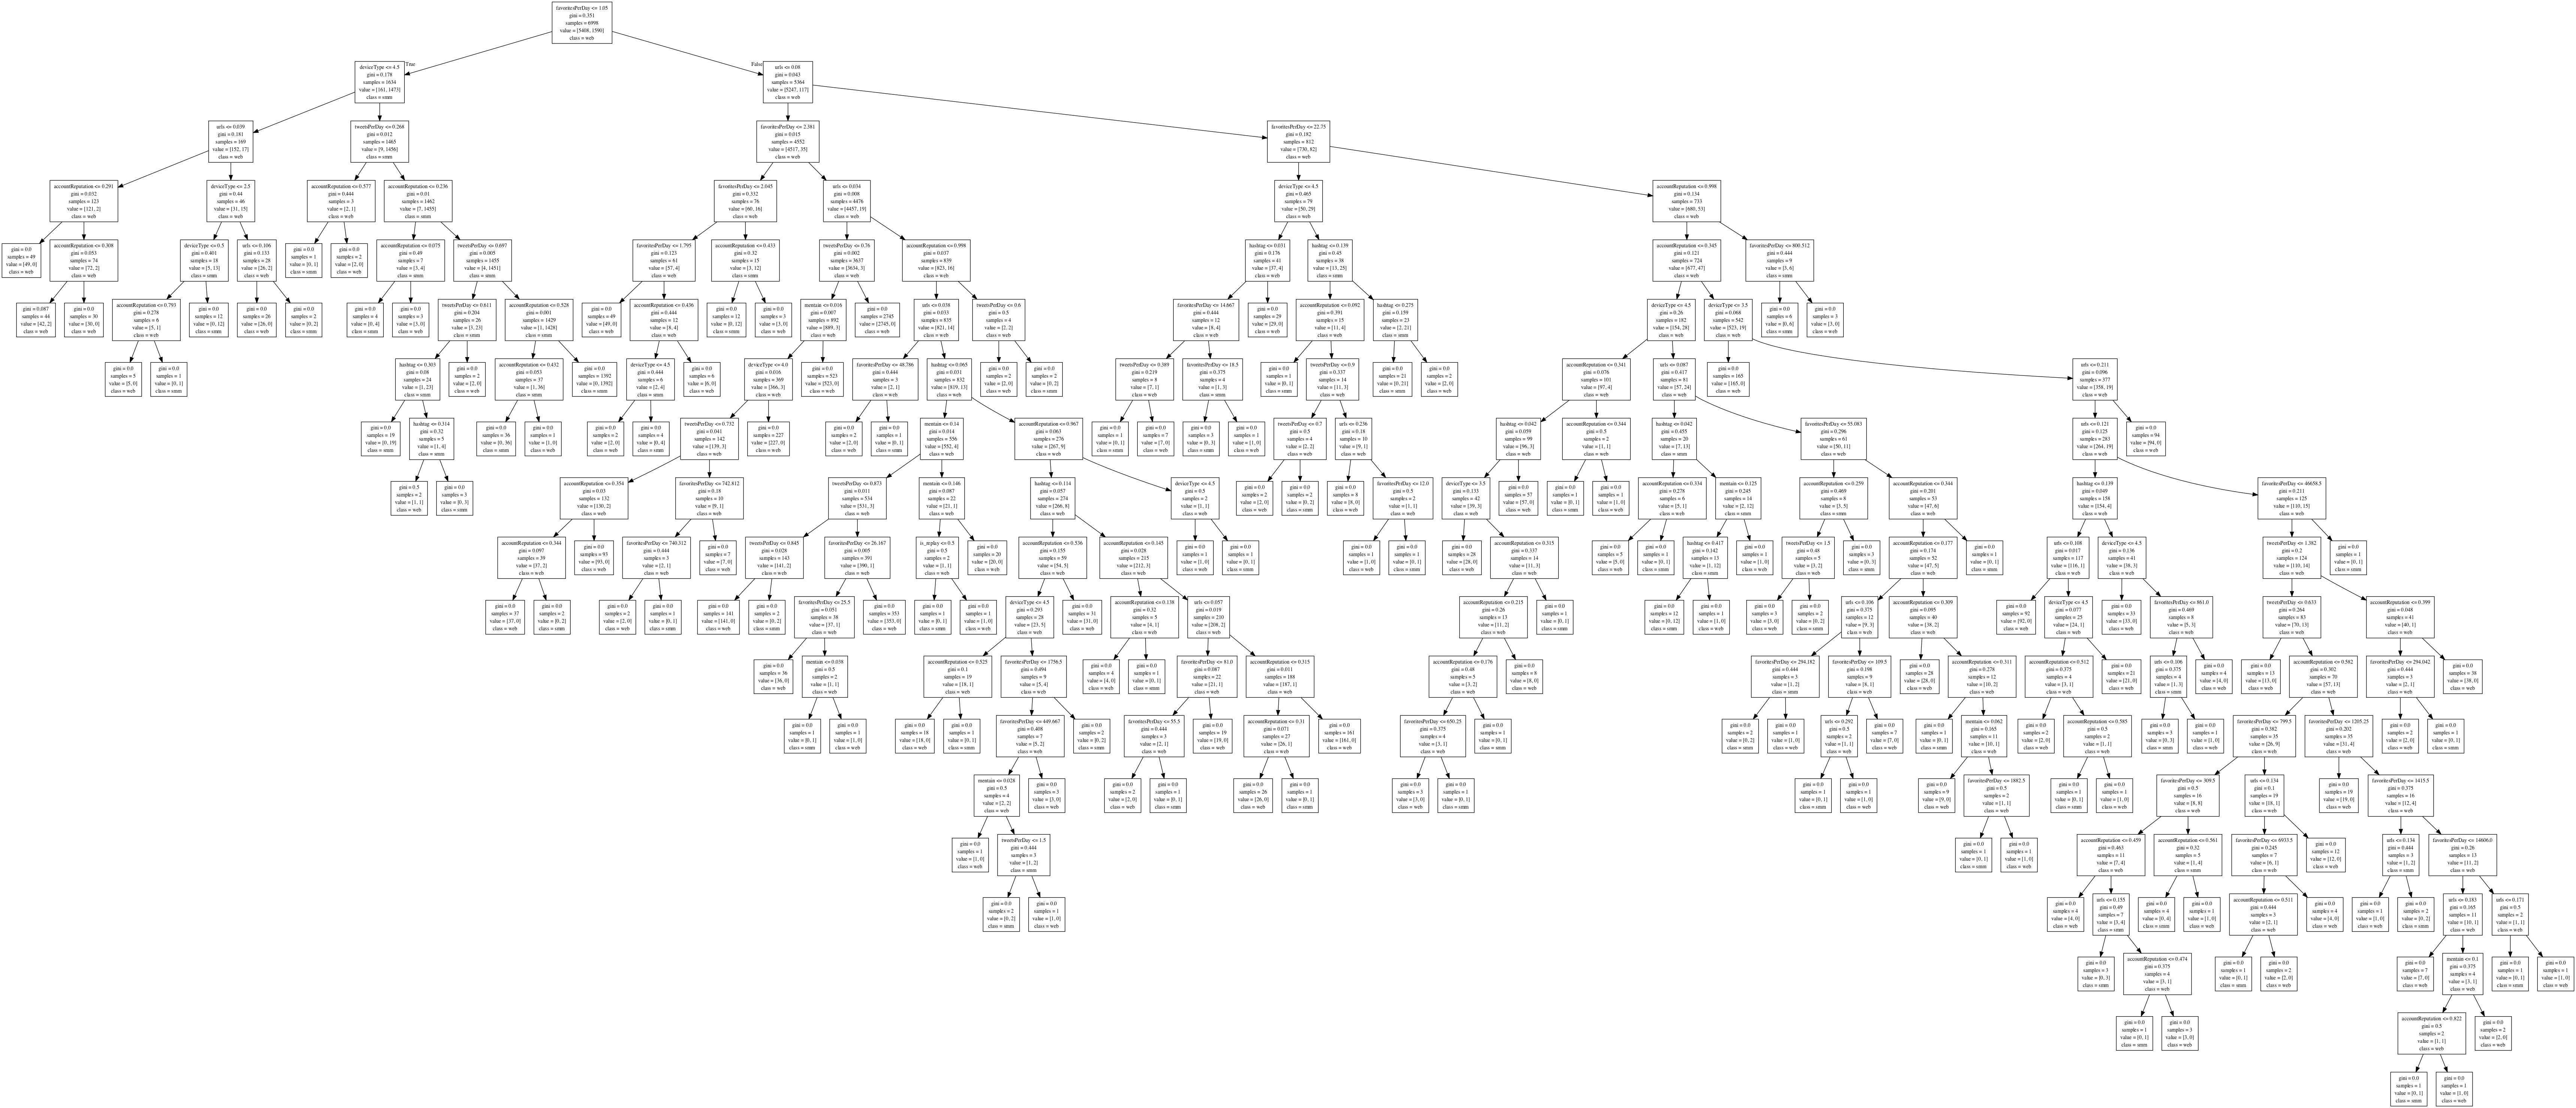

In [116]:
target_name = np.array(target_name)
feature_name = np.array(feature_name)
dot_data = tree.export_graphviz(dtree, out_file=None, 
                                feature_names=feature_name,  
                                class_names=target_name)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

# Random Forest Algorithm with train_test_split

In [117]:
# Random Forest
rfc = RandomForestClassifier(n_estimators= 2000)

In [118]:
rfc.fit(x_test, y_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [119]:
rfc_pred = rfc.predict(x_test)

In [120]:
print(confusion_matrix(y_test,rfc_pred))

print(classification_report(y_test,rfc_pred))

accuracy= np.mean(rfc_pred ==y_test)
accuracy

[[2339    0]
 [   2  659]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2339
          1       1.00      1.00      1.00       661

avg / total       1.00      1.00      1.00      3000



0.9993333333333333

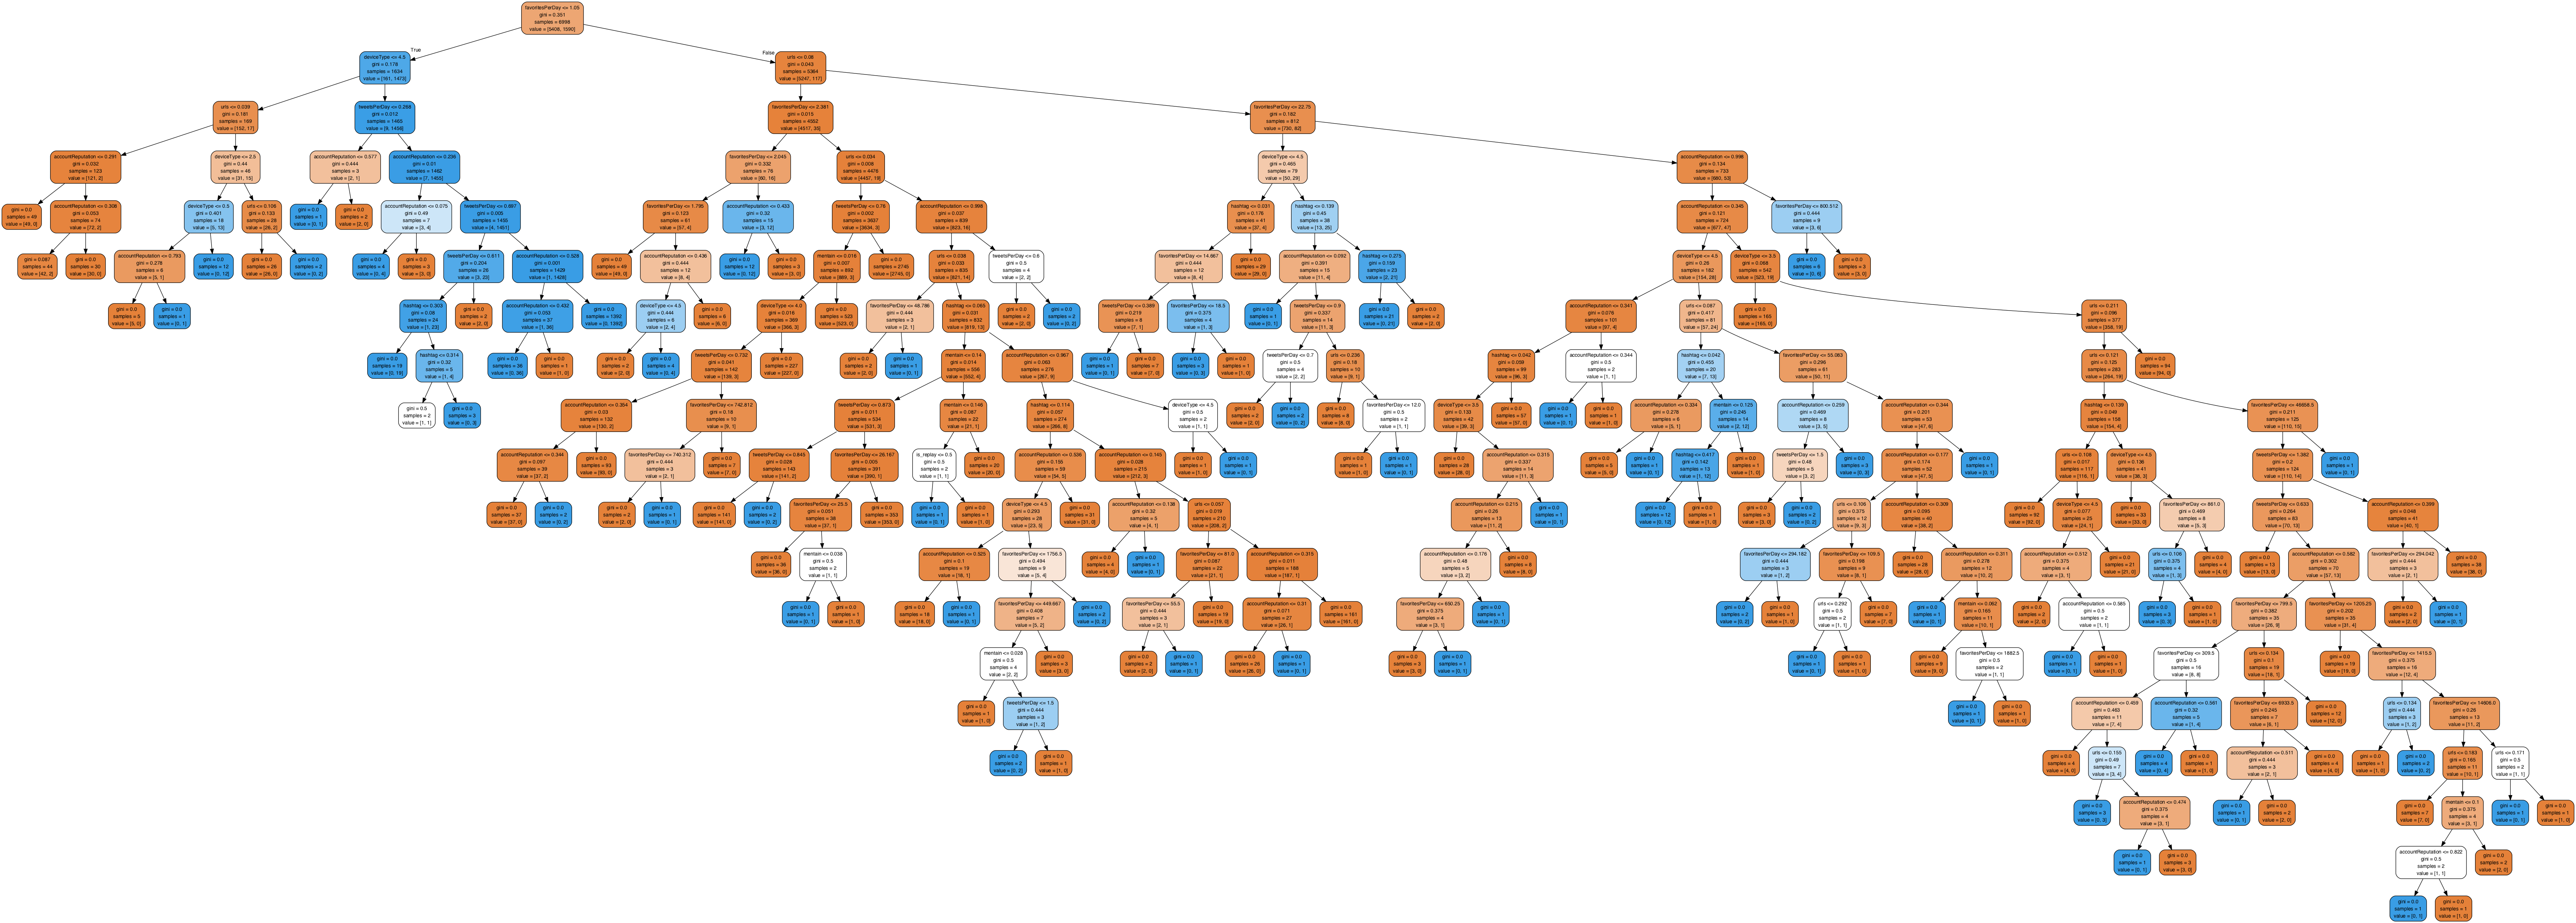

In [121]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,feature_names=feature_name, filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

# SVM Algorithm with train_test_split

In [122]:
#SVC 
model = SVC()

In [123]:
model.fit(x_test,y_test)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [124]:
predictions = model.predict(x_test)

In [125]:
print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

accuracy= np.mean(predictions ==y_test)
accuracy

[[2333    6]
 [  44  617]]
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      2339
          1       0.99      0.93      0.96       661

avg / total       0.98      0.98      0.98      3000



0.9833333333333333

In [ ]:
# Grid search take a dictionary that describe the parameters that should be ties in a model to train the grid, key is parameter value a list of settings to be tested
param_grid = {}
